# Practical work 6 : Harris Corner Detector

The goal of this pratical work is to implement the Harris-Stephen's corners detector (C. Harris and M. Stephens. A combined corner and edge detector. In Proc. Fourth Alvey Vision Conference, pages 147–151, 1988).

Recall the Harris detector computes a map of corners from an image $I$:
$$
R(x,y) = \operatorname{det}(M) - k (\operatorname{trace}(M))^2, (x,y) \text{pixels}
$$
with $k\in[0.04, 0.06]$. $M$ is the auto-correlation of image $I$:
$$
M=\begin{pmatrix}
\sum_{x,y \in W} w(x,y)I_x^2 &
\sum_{x,y \in W} w(x,y)I_xI_y \\
\sum_{x,y \in W} w(x,y)I_xI_y &
\sum_{x,y \in W} w(x,y)I_y^2 
\end{pmatrix}
=\begin{pmatrix}
A & B \\ C & D
\end{pmatrix}
$$
with $w(x,y)=\frac1{2\pi \sigma^2}e^{\frac{(x-x_c)^2 + (y-y_c)^2}{2\sigma^2}}$ a Gaussian mask centered on the window $W$. Partial derivatives $I_x$ and $I_y$ are estimated by one of the following kernels :
- Gradient:  $G_x = \begin{pmatrix} 0 & 0 & 0\\ 1 & 0 &-1 \\ 0 & 0 & 0 \end{pmatrix}$,
 $G_y = G_x^T$
- Prewitt: $G_x = \begin{pmatrix} 1 & 0 & -1\\ 1 & 0 &-1 \\ 1 & 0 & -1 \end{pmatrix}$,
 $G_y = G_x^T$
- Sobel: $G_x = \begin{pmatrix} 1 & 0 & -1\\ 2 & 0 &-2 \\ 1 & 0 & -1 \end{pmatrix}$,
 $G_y = G_x^T$
 


In [41]:
# Load useful libraries
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal

def niceDisplay14(affichages,titres=None):
    """ list[Array]*list[str] -> NoneType
        display from 1 up to 4 images or vectors with optionnal titles
        2D arrays are displayed as image with imshow()
        1D arrays are displayed as curve with plot()
    """
    
    if not type(affichages) == type([]):
        affichages = [affichages]
        
    if titres is None:
        titres = ['',]*len(affichages)
        
    if not type(titres) == type([]):
        titres = [titres]
    
    nb_affichages = len(affichages)
    if nb_affichages >4 or nb_affichages < 1 :
        raise ValueError('niceDisplay_14 : affichage should be a list of length 1 up to 4')
        
    if nb_affichages != len(titres):
        raise ValueError('niceDisplay_14 : titres must have same length than affichage')
        
    courbes = False
    for i in range(0,nb_affichages):
        s = plt.subplot(101+10*nb_affichages+i)
        s.set_title(titres[i])
        if len(affichages[i].shape)==2 and affichages[i].shape[0] > 1 and affichages[i].shape[1] > 1:
            # on affiche une image
            s.imshow(affichages[i], cmap="gray",interpolation='nearest', aspect='equal')
        else :
            # il s'agit d'une seule ligne, à afficher comme une courbe
            plt.plot(affichages[i])
            courbes=True

    agrandissement_h = nb_affichages
    agrandissement_v = nb_affichages*2 if courbes else nb_affichages
    params = plt.gcf()
    plSize = params.get_size_inches()
    params.set_size_inches( (plSize[0]*agrandissement_v, plSize[1]*agrandissement_h) )
    plt.show()

def gaussianKernel(sigma):
    """ double -> Array
        return a gaussian kernel of standard deviation sigma
    """
    n2 = np.int(3*sigma)
    x,y = np.meshgrid(np.arange(-n2,n2+1),np.arange(-n2,n2+1))
    kern =  np.exp(-(x**2+y**2)/(2*sigma*sigma))
    return kern/kern.sum()

## Exercise 1: Harris response calculation

1) Write a function `computeR(I, scale, kappa)` that returns the Harris response $R$ from an image $I$ and a scale $scale$. You will use 5 steps:
- Computation of the directionnal derivate $I_x$ and $I_y$. Use the Sobel kernel.
- Computation of the products $I_x^2$, $I_y^2$, $I_x.I_y$.
- Computation of the convolution of $I_x^2$, $I_y^2$ and $I_x.I_y$ by a gaussian kernel of size N (use given function `gaussianKernel()`)
- Computation of $\operatorname{det}(M(x,y))$ and $\operatorname{trace}(M(x,y))$ for each pixel
- Computation of $R(x,y) = \operatorname{det}(M(x,y)) - k.(\operatorname{trace}(M(x,y)))^2$. You can use $k = 0.04$.

 You can compute the convolutions by using the ```scipy.signal.convolve2d``` function. 


In [2]:
def computeR(image,scale,kappa):
    """ Array[n, m]*float*float->Array[n, m]
    """
    Ix = scipy.signal.convolve2d(image,[[1,0,-1],[2,0,-2],[1,0,-1]],mode='same')
    Iy = scipy.signal.convolve2d(image,[[1,2,1],[0,0,0],[-1,-2,-1]],mode='same')
    
    N = scale
    sigma = (N - 1)/6
    Ix2 = scipy.signal.convolve2d(Ix**2, gaussianKernel(sigma),mode='same')
    Iy2 = scipy.signal.convolve2d(Iy**2, gaussianKernel(sigma),mode='same')
    IxIy = scipy.signal.convolve2d(Ix*Iy,gaussianKernel(sigma),mode='same')
    
    det_M   = Ix2*Iy2 - (IxIy*IxIy)
    trace_M = Ix2 + Iy2
    R = det_M - kappa*(trace_M**2)
    return R

2) Write a script that displays the Harris response for the image ```img/house2.png``` along with the original image. Use a gaussian window of size $W=15$ pixels.

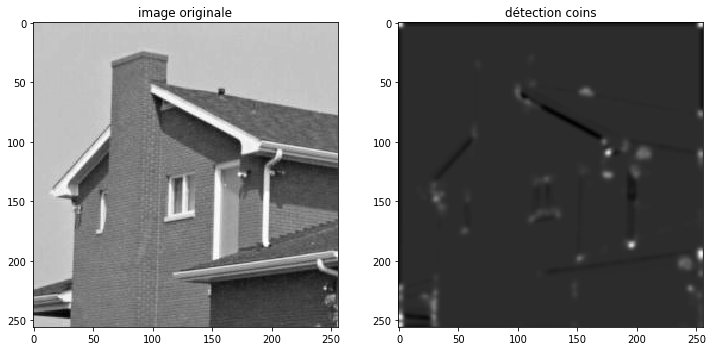

In [43]:
img = np.array(Image.open('img/house2.png'))
ret = computeR(img, 15, 0.04)

niceDisplay14([img,ret], ["image originale", "détection coins" ])

3) Write in a few lines an interpretation of the results, explaining how the Harris response allows to detect and discriminate homogeneous areas, edges and corners.

On remarque que les bords dans l'image sont en noirs (correspondant à des valeurs négatives de R), les zones homogènes sont grises (correspondant à des valeurs positives faibles de R) et les coins sont blancs (correspondant à des valeurs positives fortes de R).  
On peut donc en observant en fonction des valeurs de R les zones de bords, coins et zones homogenes étant respectivement les valeurs de R négatives, positives fortes et positives faibles.

## Exercise 2 : Harris corner detector
From the Harris response calculated at exercise 1, we will write all the functions needed for the Harris detector. Write the following functions: 

1) A function `thresholdR(R, thres)` that calculates and returns the binary thresholding $R_b$ of the response $R$ according to the threshold $thres$

In [14]:
def thresholdR(R, thres):
    """ Array[n, m] * float -> Array[n, m]
    """
    return np.where(R<thres, 0, 1)

2) A function `Rnms(R, Rbin)` that performs a non-maximum supression from the response $R$ and the binarized response $R_{bin}$. It returns the image $R_{locmax}$ (same size as $R$) =1 where $R_{bin}=1$ and the pixel has a greater value $R$ than its 8 nearest neighbors.

**Bonus**: Write a faster version of the script using Numpy function `np.roll()`.

In [5]:
def rnms(image_harris):
    """ Array[n, m] -> Array[n, m] 
    """
    R = image_harris
    for i in range(3):
        for j in range(3):
            if not i and not j:
                continue
                
            img = np.roll(image_harris, i-1, axis = 0)
            img = np.roll(img, j-1, axis = 1)
            R   = np.where(R<img, 0, R)
            
    return np.where(R!=0, 1, 0)

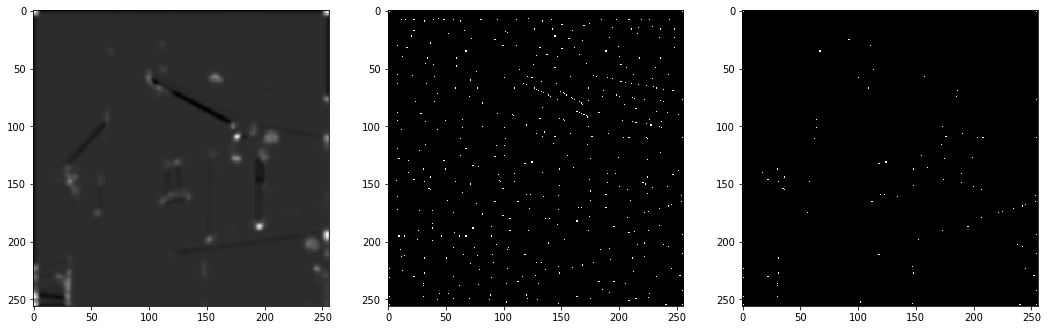

In [44]:
R1 = rnms(ret)
R2 = thresholdR(ret, 10000000)
R = (R1+R2)//2

niceDisplay14([ret,R1,R])

3) Write a function ``cornerDetector(image, scale, kappa, thresh)`` that returns an array of the same size as the image. The array takes two values: 1 where a corner is detected and 0 elsewhere.

In [7]:
def cornerDetector(image, sigma, kappa, thres):
    """ Array[n, m]*float*float*float -> Array[n, m]
    """
    R = computeR(image, sigma, kappa)
    R1 = rnms(R)
    R2 = thresholdR(R, thres)
    R = (R1+R2)//2
    return R
    

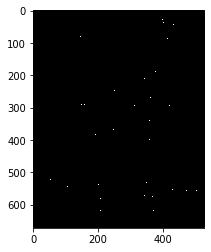

In [19]:
R = cornerDetector(img, 15, 0.04, 10000000)
niceDisplay14([R])

4 ) Display the detected corners on the original image for the image ```img/house2.png```. Each detected corner will be displayed as a small red disk. You can use the functions ```np.nonzero()``` and ```plt.scatter()``` to that purpose.

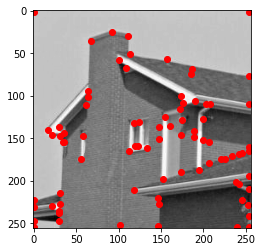

In [52]:
R = cornerDetector(img, 15, 0.04, 1e7)
y,x = np.nonzero(R)
plt.scatter(x,y, color = 'red')
plt.imshow(img, cmap = 'gray')
plt.show()

5) Evaluate the performances of the corner detector. Try to find good values for Sigma and Threshold.

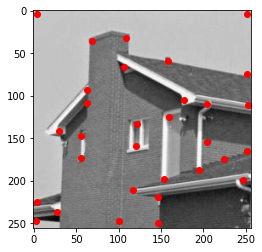

sans les points au bord de l'image


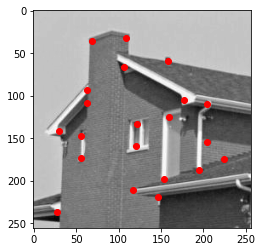

In [59]:
R = cornerDetector(img, 43, 0.04, 0.5*1e7)
y,x = np.nonzero(R)
plt.scatter(x,y, color = 'red')
plt.imshow(img, cmap = 'gray')
plt.show()
# sans les bords
y1 = []
x1 = []
for yv,xv in zip(y,x):
    if not((yv < 10 or yv > len(img) - 10) or (xv < 10 or xv > len(img) - 10)):
        y1+=[yv]
        x1+=[xv]
print("sans les points au bord de l'image")
plt.scatter(x1,y1, color = 'red')
plt.imshow(img, cmap = 'gray')
plt.show()

La detection est plutot bonne, mais on a quelques points qui ne sont pas vraiment des coins, par exemple le point sur le toit n'est pas vraiment un coin.   
On observe une bonne détéction avec une échelle de 43 et un seuillage de 0.5\*1e7.

## Exercise 3 : Properties of Harris corner detector

The goal of this exercice is to study some invariance properties of Harris detector.

1) Write a script that detects the corners on the images ```img/toyHorse1.png``` and ```img/toyHorse2.png``` with a scale of 15 and appropriate threshold value. Display the detected corners on the images.

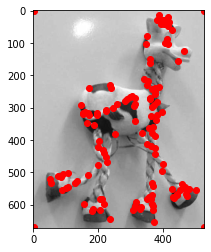

In [103]:
img = Image.open('img/toyHorse1.png')
R = cornerDetector(img, 15, 0.04, 1e8)
y,x = np.nonzero(R)

plt.scatter(x,y, color = 'red')
plt.imshow(img, cmap = 'gray')


plt.show()

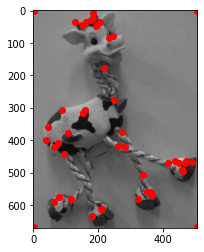

In [102]:
img2 = Image.open('img/toyHorse2.png')
R2 = cornerDetector(img2, 15, 0.04, 1e8)
y2,x2 = np.nonzero(R2)
plt.scatter(x2,y2, color = 'red')
plt.imshow(img2, cmap = 'gray')
plt.show()

2) What are the dynamic ranges of these two images ?

In [28]:
print("image 1 : dynamic range [",np.array(img).min(),np.array(img).max(),"]")
print("image 1 : moyenne ",np.array(img).mean())
print("image 2 : dynamic range [",np.array(img2).min(),np.array(img2).max(),"]")
print("image 2 : moyenne ",np.array(img2).mean())

image 1 : dynamic range [ 1 255 ]
image 1 : moyenne  166.47176838599333
image 2 : dynamic range [ 0 253 ]
image 2 : moyenne  111.72060012286998


3) What are the transformations beetween the two images ?

On realise une rotation de l'image et une transformation affine de la luminosité.  

4) Using a fixed threshold, is the detection invariant to rotation ? To affine transformation of brightness ?

Oui pour les deux, on voit bien que les points sont environ les mêmes dans les 2 images (on observe moins de points dans la seconde car il ne s'agit pas d'une reel rotation de l'image).